## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

## Memuat Data

In [3]:
data = pd.read_excel("Dataset Lomba Data Analytics TECHFEST 2025.xlsx")
data_clean = data[~data.apply(lambda row: row.astype(str).str.strip().str.lower().eq("null")).any(axis=1)]

In [4]:
data_clean.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 0 to 37
Data columns (total 10 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Provinsi                                                        33 non-null     object 
 1   IPM                                                             33 non-null     float64
 2   Pagu TKDD                                                       33 non-null     float64
 3   Realisasi TKDD                                                  33 non-null     float64
 4   Jumlah Penduduk                                                 33 non-null     float64
 5   Anggaran APBN per kapita                                        33 non-null     float64
 6   Persentase Penduduk Miskin                                      33 non-null     float64
 7   Produk Domestik Regional Bruto (PDRB) Atas Dasar Harga Berla

## 01. Analisis Perbandingan Pagu dan Realisasi TKDD

In [5]:
def bandingkanTKDD(data, kolom_pagu='Pagu TKDD', kolom_realisasi='Realisasi TKDD'):
    # Pastikan hanya baris yang tidak null
    df = data[[kolom_pagu, kolom_realisasi]].dropna()

    # Plot Clustered Bar Chart
    plt.figure(figsize=(12, 6))
    index = range(len(df))
    bar_width = 0.35

    plt.bar([i - bar_width/2 for i in index], df[kolom_pagu], width=bar_width, label='Pagu TKDD')
    plt.bar([i + bar_width/2 for i in index], df[kolom_realisasi], width=bar_width, label='Realisasi TKDD')

    plt.xlabel('Indeks Data')
    plt.ylabel('Nilai')
    plt.title('Perbandingan Pagu dan Realisasi TKDD')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Uji t Berpasangan
    t_stat, p_value = ttest_rel(df[kolom_pagu], df[kolom_realisasi])

    print("\n📊 Hasil Uji t Berpasangan:")
    print(f"Statistik t: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("❗Terdapat perbedaan signifikan antara Pagu dan Realisasi TKDD (p < 0.05).")
    else:
        print("✅ Tidak terdapat perbedaan signifikan antara Pagu dan Realisasi TKDD (p ≥ 0.05).")


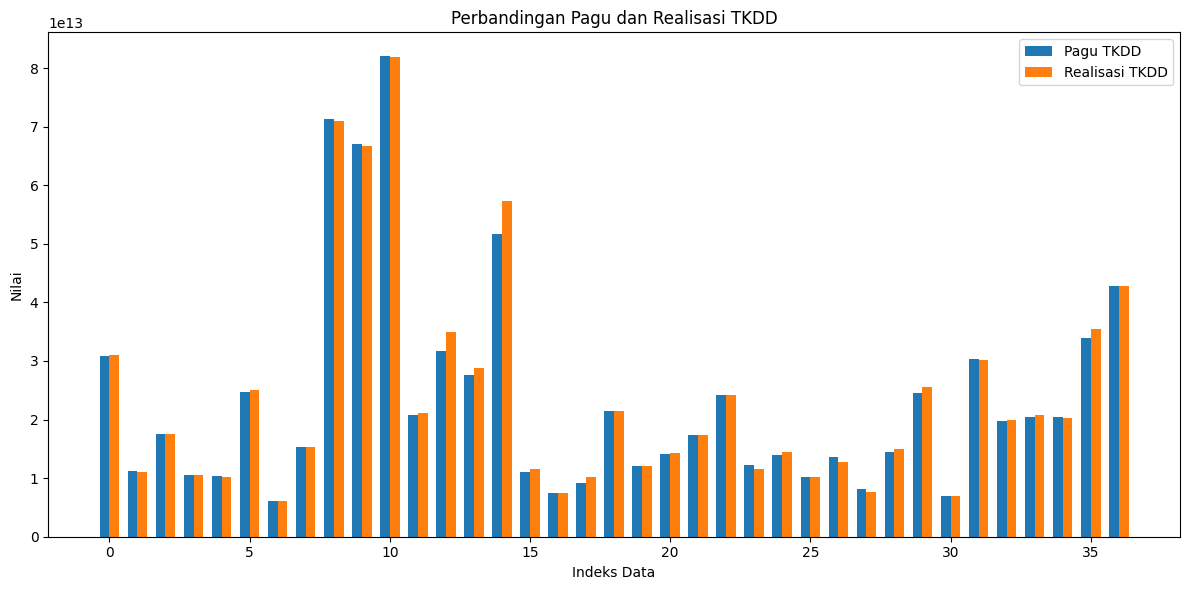


📊 Hasil Uji t Berpasangan:
Statistik t: -1.9521
p-value: 0.0587
✅ Tidak terdapat perbedaan signifikan antara Pagu dan Realisasi TKDD (p ≥ 0.05).


In [6]:
bandingkanTKDD(data_clean)

## 02. Perhitungan Persentase Realisasi TKDD

In [7]:
def hitungPersentaseRealisasi(
    data,
    kolom_pagu='Pagu TKDD',
    kolom_realisasi='Realisasi TKDD',
    kolom_persen='Persentase Realisasi',
    kolom_klasifikasi='Klasifikasi Realisasi'
):
    df = data.copy()

    # Hindari pembagian nol
    df = df[df[kolom_pagu] != 0]

    # Hitung persentase realisasi
    df[kolom_persen] = (df[kolom_realisasi] / df[kolom_pagu]) * 100

    # Klasifikasi berdasarkan persentase
    def klasifikasi(persen):
        if persen < 90:
            return 'Di Bawah Target'
        elif persen <= 100:
            return 'Sesuai Target'
        else:
            return 'Melebihi Target'

    df[kolom_klasifikasi] = df[kolom_persen].apply(klasifikasi)

    return df

In [8]:
data = hitungPersentaseRealisasi(data_clean)

In [27]:
def buatTabelFrekuensi(data, kolom_klasifikasi='Klasifikasi Realisasi'):
    frekuensi = data[kolom_klasifikasi].value_counts().reset_index()
    frekuensi.columns = ['Kategori', 'Jumlah']
    frekuensi['Persentase'] = (frekuensi['Jumlah'] / frekuensi['Jumlah'].sum()) * 100
    return frekuensi


In [28]:
frekuensi = buatTabelFrekuensi(data)

In [29]:
frekuensi

,Kategori,Jumlah,Persentase
0,Melebihi Target,20,52.631579
1,Sesuai Target,18,47.368421


In [30]:
dataFinal = data.dropna()

## 03. Identifikasi Faktor-Faktor yang Mempengaruhi Realisasi TKDD

In [31]:
import pandas as pd
import statsmodels.api as sm

# Variabel dependen
Y = dataFinal['Realisasi TKDD']

# Variabel independen
X = dataFinal[['IPM','Pagu TKDD','Jumlah Penduduk', 
               'Anggaran APBN per kapita', 
               'Persentase Penduduk Miskin',
               'Produk Domestik Regional Bruto (PDRB) Atas Dasar Harga Berlaku',
               'Produk Domestik Regional Bruto per Kapita HB',
               'Laju Pertumbuhan PDRB atas dasar konstan 2010']]

# Tambahkan konstanta
X = sm.add_constant(X)

# Bentuk model
model = sm.OLS(Y, X).fit()

# Buat DataFrame hasil regresi
params_df = pd.DataFrame({
    'Koefisien': model.params,
    't-statistik': model.tvalues,
    'p-value': model.pvalues
})

# Tambahkan kolom keputusan (alpha = 0.05)
params_df['Keputusan'] = params_df['p-value'].apply(lambda p: 'Signifikan' if p < 0.05 else 'Tidak Signifikan')

# Tampilkan hasil
print("Hasil Regresi Parameter:")
print(params_df)

# Uji simultan (uji F)
f_stat = model.fvalue
f_pvalue = model.f_pvalue
f_keputusan = 'Signifikan' if f_pvalue < 0.05 else 'Tidak Signifikan'

# Tampilkan hasil uji simultan
print("\n=== Hasil Uji Simultan (F-statistik) ===")
print(f"F-statistik : {f_stat:.4f}")
print(f"p-value     : {f_pvalue:.4f}")
print(f"Keputusan   : {f_keputusan}")

Hasil Regresi Parameter:
                                                       Koefisien  t-statistik  \
const                                              -5.358485e+08    -3.140665   
IPM                                                -9.860275e+09    -1.280254   
Pagu TKDD                                           1.069150e+00    62.597458   
Jumlah Penduduk                                     5.493821e+02     0.036786   
Anggaran APBN per kapita                           -5.411009e+04    -0.818201   
Persentase Penduduk Miskin                         -5.511628e+10    -2.013895   
Produk Domestik Regional Bruto (PDRB) Atas Dasa... -1.890708e+06    -4.480198   
Produk Domestik Regional Bruto per Kapita HB        1.868021e+04     4.355250   
Laju Pertumbuhan PDRB atas dasar konstan 2010      -2.133232e+10    -0.436959   

                                                         p-value  \
const                                               4.295868e-03   
IPM                         

In [32]:
params_df

,Koefisien,t-statistik,p-value,Keputusan
const,-5.358485e+08,-3.140665,4.295868e-03,Signifikan
IPM,-9.860275e+09,-1.280254,2.122080e-01,Tidak Signifikan
Pagu TKDD,1.069150e+00,62.597458,5.317579e-29,Signifikan
Jumlah Penduduk,5.493821e+02,0.036786,9.709479e-01,Tidak Signifikan
Anggaran APBN per kapita,-5.411009e+04,-0.818201,4.209732e-01,Tidak Signifikan
Persentase Penduduk Miskin,-5.511628e+10,-2.013895,5.490165e-02,Tidak Signifikan
Produk Domestik Regional Bruto (PDRB) Atas Dasar Harga Berlaku,-1.890708e+06,-4.480198,1.433622e-04,Signifikan
Produk Domestik Regional Bruto per Kapita HB,1.868021e+04,4.355250,1.981469e-04,Signifikan
Laju Pertumbuhan PDRB atas dasar konstan 2010,-2.133232e+10,-0.436959,6.658921e-01,Tidak Signifikan


## 04. Hubungan Realisasi TKDD dengan IPM

=== Korelasi Pearson ===
Koefisien Korelasi: 0.1666 (p-value: 0.3541)

=== Hasil Regresi Linier Sederhana (X Terdistandarisasi) ===
Persamaan: IPM = 73.7318 + 73.7318 * Z_Realisasi_TKDD
Koefisien Slope: 73.7318
t-statistik    : 110.8373
p-value        : 0.0000
Keputusan      : Signifikan


/tmp/ipykernel_19679/3024702612.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[0]  # atau model.params['Realisasi TKDD'] jika nama kolom disesuaikan
/tmp/ipykernel_19679/3024702612.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stat = model.tvalues[0]
/tmp/ipykernel_19679/3024702612.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = model.pvalues[0]


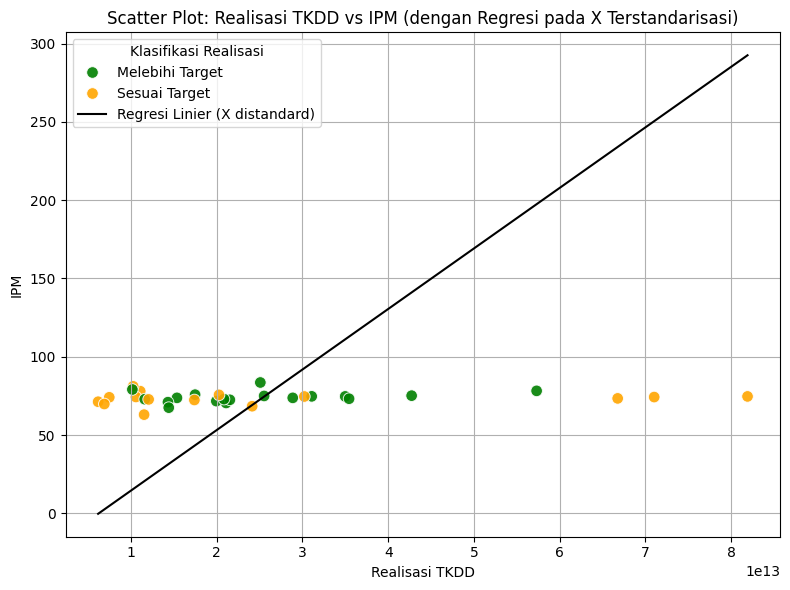

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

# 1. Korelasi Pearson
corr, pval_corr = stats.pearsonr(dataFinal['Realisasi TKDD'], dataFinal['IPM'])
print(f"=== Korelasi Pearson ===")
print(f"Koefisien Korelasi: {corr:.4f} (p-value: {pval_corr:.4f})\n")

# 2. Standarisasi variabel X (Realisasi TKDD)
X_raw = dataFinal['Realisasi TKDD']
X_std = (X_raw - X_raw.mean()) / X_raw.std()

Y = dataFinal['IPM']
X_with_const = sm.add_constant(X_std)
model = sm.OLS(Y, X_with_const).fit()

intercept = model.params['const']
slope = model.params[0]  # atau model.params['Realisasi TKDD'] jika nama kolom disesuaikan
t_stat = model.tvalues[0]
p_val = model.pvalues[0]
keputusan = 'Signifikan' if p_val < 0.05 else 'Tidak Signifikan'

# 3. Tampilkan hasil regresi standar
print(f"=== Hasil Regresi Linier Sederhana (X Terdistandarisasi) ===")
print(f"Persamaan: IPM = {intercept:.4f} + {slope:.4f} * Z_Realisasi_TKDD")
print(f"Koefisien Slope: {slope:.4f}")
print(f"t-statistik    : {t_stat:.4f}")
print(f"p-value        : {p_val:.4f}")
print(f"Keputusan      : {keputusan}")

# 4. Scatter plot (tetap pakai X asli agar plotnya bermakna)
plt.figure(figsize=(8, 6))

# Titik-titik berwarna
sns.scatterplot(
    data=dataFinal,
    x='Realisasi TKDD',
    y='IPM',
    hue='Klasifikasi Realisasi',
    palette={'Di Bawah Target': 'red', 'Sesuai Target': 'orange', 'Melebihi Target': 'green'},
    s=70,
    alpha=0.9
)

x_vals = np.linspace(X_raw.min(), X_raw.max(), 100)
x_std_vals = (x_vals - X_raw.mean()) / X_raw.std()
y_vals = intercept + slope * x_std_vals
plt.plot(x_vals, y_vals, color='black', label='Regresi Linier (X distandard)')

# Finalisasi plot
plt.title('Scatter Plot: Realisasi TKDD vs IPM (dengan Regresi pada X Terstandarisasi)')
plt.xlabel('Realisasi TKDD')
plt.ylabel('IPM')
plt.grid(True)
plt.legend(title='Klasifikasi Realisasi')
plt.tight_layout()
plt.show()
